# Import libraries

In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

# Define constants

In [2]:
c = 299792.458
H0 = 75

# Some key functions

In [3]:
def scale_factor(z):
    return 1/(1+z)

# Load the data

In [4]:
sn_z_near, sn_mag_near, sn_mag_err_near =  np.loadtxt("sn_data_nearby.txt", unpack = True, usecols=(1,2,3))
sn_z_far, sn_mag_far, sn_mag_err_far =  np.loadtxt("sn_data_distant.txt", usecols=(1,2,3), unpack = True)
sn_z, sn_mag, sn_mag_err = np.loadtxt("sn_data.txt", usecols=(1,2,3), unpack = True)



# Finding peak luminosity

In [45]:
f0 = 6.61* 10**-9 * 10**(-7) * (3.2408*10**(-25))**(-2)

def co_moving_dist_near(z):
    return z*c/H0

def mag_model_near(z, *Lpl):
    rc = co_moving_dist_near(z)
    flux = Lpl[0]/(4*np.pi*(rc)**2)
    argument = flux/f0
    mag = -2.5*np.log10(argument)
    return mag

# Chi squared mininimisation to find peak luminosity

In [58]:
initial = np.array([100000000000]) #initial guess for L_peak_lambda
deg_freedom = sn_z_near.size - initial.size #change x to actual data values
popt, cov = scp.optimize.curve_fit(mag_model_near, # function to fit
                                     sn_z_near, # x data
                                     sn_mag_near, # y data
                                     sigma=sn_mag_err_near, # set yerr as the array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial, # starting point for fit
                                     check_finite=True)
# define variables
print(popt)
LPeakLambda = 3.2*10**32
def chisq(model_params, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(x_data)):
        chisqval += ((y_data[i] - mag_model_near(x_data[i], *model_params))/y_err[i])**2 
        # NOTE again the asterisk (*) before 'model_params' here!
    return chisqval

chisq_min = chisq(popt, sn_z_near, sn_mag_near, sn_mag_err_near)
reduced_chisq_min = chisq_min/deg_freedom
print(reduced_chisq_min)
popt_errs = np.sqrt(np.diag(cov))
Lpl_err = popt_errs[0]
for i in range(len(popt)):
    print('optimised parameter[{}] = {} +/- {}'.format(i, popt[i], popt_errs[i]))
print(chisq_min)

[2.95680691e+32]
1.4004090705408574
optimised parameter[0] = 2.956806910703256e+32 +/- 1.2650796315309436e+31
23.806954199194575


# Chi-squared plot for finding peak luminosity

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
C:\Users\milan\AppData\Local\Temp\ipykernel_23440\253205069.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("${L_{\lambda, peak}}$ ${(W Å^{-1})}$")


17


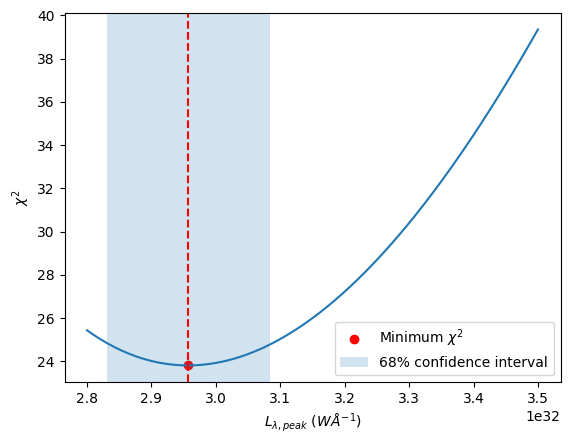

In [59]:
Lpeak_trial_vals = np.linspace(2.8*10**32, 3.5*10**32, 100000)
chisq_vals = np.zeros(len(Lpeak_trial_vals))
for i in range(len(Lpeak_trial_vals)):
    trial_Lpeak_val = np.array([Lpeak_trial_vals[i]])
    chisq_vals[i] = chisq(np.array(trial_Lpeak_val), sn_z_near, sn_mag_near, sn_mag_err_near)
print(deg_freedom)
red_chisq_vals = chisq_vals/deg_freedom
plt.figure(1)
plt.plot(Lpeak_trial_vals, chisq_vals)
plt.xlabel("${L_{\lambda, peak}}$ ${(W Å^{-1})}$")
plt.ylabel("${χ^{2}}$")
min_chisq = np.min(chisq_vals)
optimised_Lpl = Lpeak_trial_vals[np.argmin(chisq_vals)]
plt.scatter(optimised_Lpl, min_chisq, label = "Minimum ${χ^{2}}$", color = "red")
plt.axvline(optimised_Lpl, 0, color = "red", linestyle = "--")
min_chisq_plus = min_chisq + 1
min_chisq_minus = min_chisq - 1
plt.axvspan(optimised_Lpl - Lpl_err, optimised_Lpl + Lpl_err, alpha = 0.2, label = "68% confidence interval")
plt.legend()
plt.savefig("LPeakLambda-chiSquared-graph")
plt.show()

# Plotting mag-redshift data for nearby SNIa

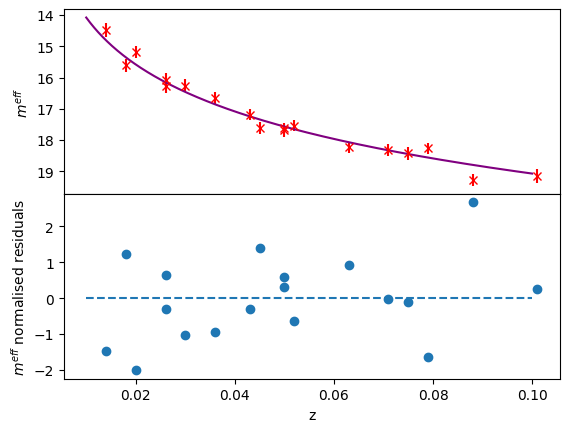

In [60]:
def zero_funct(x):
    return 0*x
trial_z = np.linspace(0.01, 0.1, 1000)
trial_mag = mag_model_near(trial_z, *popt)

norm_resid = (sn_mag_near - mag_model_near(sn_z_near, *popt))/sn_mag_err_near
fig, axs = plt.subplots(2, 1, sharex = True)
axs[0].errorbar(sn_z_near, sn_mag_near, yerr=sn_mag_err_near, marker = "x", linestyle = 'None', color = "red")
axs[0].plot(trial_z, trial_mag, color = "purple")
#axs[0].errorbar(sn_z_far, sn_mag_far, yerr=sn_mag_err_far, marker = "x", linestyle = 'None', color = "blue", label = "distant SN")
axs[1].scatter(sn_z_near, norm_resid)
axs[1].plot(trial_z, zero_funct(trial_z), linestyle = "dashed")
plt.xlabel("z")
axs[0].set_ylabel("${m^{eff}}$")
plt.ylabel("${m^{eff}}$ normalised residuals")
fig.subplots_adjust(hspace=0)
#axs[0].legend()
axs[0].invert_yaxis()
plt.savefig("effMagNearby-redshift-normResid-graph")
plt.show()

# Model: predicted magnitudes of SNIa

In [61]:
def Friedmann_eq(z, omega_DE):
    omega_M = 1 - omega_DE
    a = scale_factor(z)
    return H0*np.sqrt(omega_M/(a**3) + omega_DE + (1-omega_M-omega_DE)/(a**2))

def integrand(z, omega_DE):
    return c/Friedmann_eq(z, omega_DE)

def co_moving_dist(z_up, omega_DE):
    dist, err = scp.integrate.quad(integrand, 0, z_up, args = (omega_DE))
    return dist

def mag_model(z, omega_DE):
    rc = co_moving_dist(z, omega_DE)
    flux = LPeakLambda/(4*np.pi*(rc**2)*((1+z)**2))
    argument = flux/f0
    mag = -2.5*np.log10(argument)
    return mag

# Finding energy densities

minimum chi-squared value is 103.14328818013801, and occurs at a dark energy density of 0.686868686868687 for 60 degrees of freedom


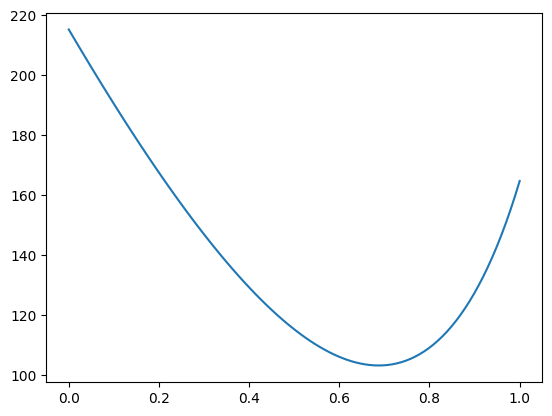

In [63]:
trial_DE_vals = np.linspace(0,1,100)
#print(trial_DE_vals)
DoF = sn_z.size
chisquared_vals = np.zeros(len(trial_DE_vals))
i1 = 0
for trial_DE in trial_DE_vals:
    #print(f"\ntrial value: {trial_DE}")
    for i2 in range(len(sn_z)):
        redshift = sn_z[i2]
        mag_predicted = mag_model(redshift, trial_DE)
        mag_actual = sn_mag[i2]
        mag_actual_err = sn_mag_err[i2]
        sq_norm_resid = ((mag_predicted-mag_actual)/mag_actual_err)**2
        chisquared_vals[i1] += sq_norm_resid
        #print(f"redshift: {redshift}, mag_pred: {mag_predicted}, mag_act: {mag_actual}, chisq: {sq_norm_resid}, tally: {chisquared_vals[i1]}")
    i1 += 1
#print(chisquared_vals)
index_min_chisq = np.argmin(chisquared_vals)
min_chisq_val = chisquared_vals[index_min_chisq]
optimised_DE = trial_DE_vals[index_min_chisq]
print(f"minimum chi-squared value is {min_chisq_val}, and occurs at a dark energy density of {optimised_DE} for {DoF} degrees of freedom")
plt.figure()
plt.plot(trial_DE_vals, chisquared_vals)
plt.show()



# Chi-squared minimisation to find energy densities of matter and dark energy

In [10]:
initial = np.array([0.5]) #initial guess for omega_DE
deg_freedom = sn_z.size - initial.size
popt, cov = scp.optimize.curve_fit(mag_model, # function to fit
                                     sn_z, # x data
                                     sn_mag, # y data
                                     sigma=sn_mag_err, # set yerr as the array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial, # starting point for fit
                                     check_finite=True)

def chisq(model_params, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(x_data)):
        chisqval += ((y_data[i] - mag_model(x_data[i], *model_params))/y_err[i])**2 
        # NOTE again the asterisk (*) before 'model_params' here!
    return chisqval

chisq_min = chisq(popt, sn_z, sn_mag, sn_mag_err)
reduced_chisq_min = chisq_min/deg_freedom
print(reduced_chisq_min)
popt_errs = np.sqrt(np.diag(cov))
for i in range(len(popt)):
    print('optimised parameter[{}] = {} +/- {}'.format(i, popt[i], popt_errs[i]))

[0.458 0.354 0.425 0.374 0.42  0.372 0.378 0.453 0.465 0.498 0.655 0.4
 0.615 0.48  0.45  0.388 0.57  0.49  0.495 0.656 0.828 0.45  0.43  0.58
 0.763 0.526 0.172 0.619 0.592 0.55  0.18  0.374 0.472 0.43  0.657 0.612
 0.32  0.579 0.45  0.581 0.416 0.83  0.03  0.05  0.026 0.075 0.026 0.014
 0.101 0.02  0.036 0.045 0.043 0.018 0.079 0.088 0.063 0.071 0.052 0.05 ]


IndexError: index 99999 is out of bounds for axis 0 with size 60